In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap


In [17]:
df=pd.read_csv("Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
#Remove Customer ID
df=df.drop("customerID",axis=1, errors='ignore')
#Convert TotalCharges to numeric
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"],errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
#Replace Yes/No with 1/0
binary_cols=["Partner","Dependents","PhoneService","PaperlessBilling","Churn"]
for col in binary_cols:
  df[col]=df[col].map({"Yes":1,"No":0}) # Corrected 'yes' to 'Yes' to match data
#one-hot encode remaining categorical variables
df=pd.get_dummies(df,drop_first=True)
df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,True,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,...,False,False,False,False,False,False,False,False,True,False


In [21]:
X=df.drop("Churn",axis=1)
y=df["Churn"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [34]:
#Logistic Regression
log_model=LogisticRegression(max_iter=5000)
log_model.fit(X_train,y_train)
#Random Forest
rf_model=RandomForestClassifier(n_estimators=300,random_state=42)
rf_model.fit(X_train,y_train)
#XGBoost
xgb_model=XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=5,subsample=0.9,colsample_bytree=0.9,eval_metric='logloss')
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

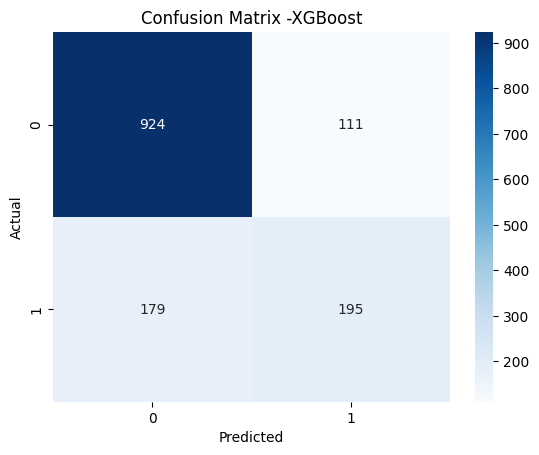

In [29]:
#Confusion Matrix
y_pred=xgb_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues")
plt.title("Confusion Matrix -XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



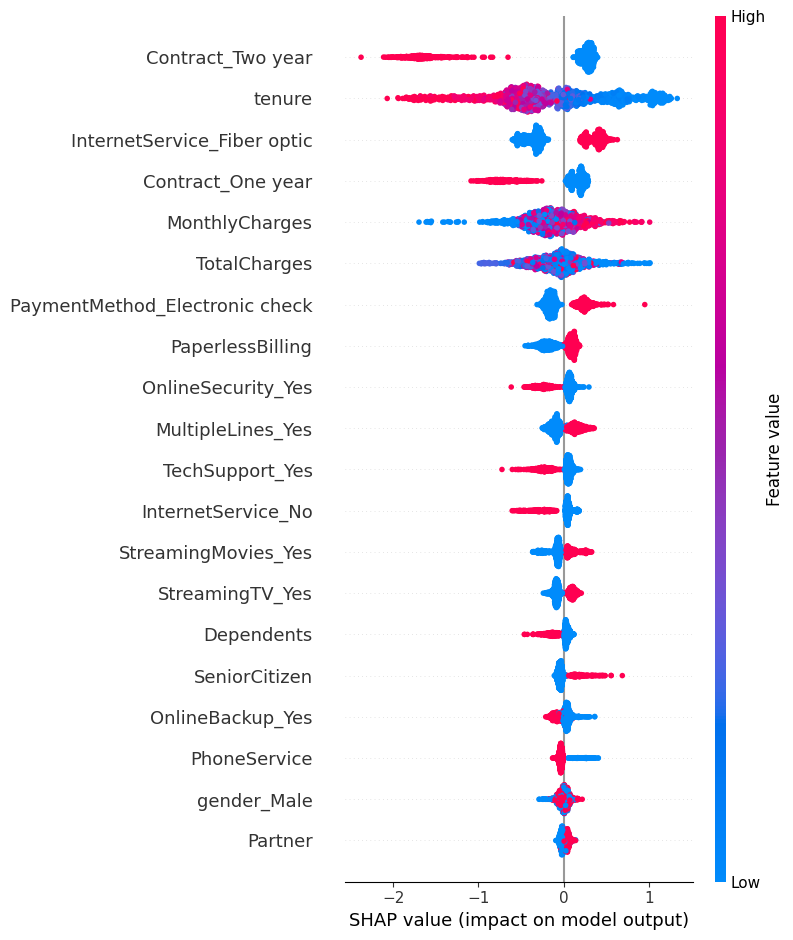

In [33]:
#SHAP
explainer=shap.TreeExplainer(xgb_model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test)